In [1]:
import os
import cv2
import keras
import imutils

import numpy as np 
import matplotlib.pyplot as plt
import segmentation_models as sm


import imgaug.augmenters as iaa


from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D, Activation

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
# seq = iaa.Sequential([
#     iaa.Flipud(1), # crop images from each side by 0 to 16px (randomly chosen)
#     iaa.Fliplr(1), # horizontally flip 50% of the images
# ])


In [3]:
train_dir = "../train"
test_dir = "../test"

In [4]:
def thresholder(img):
    ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

    thresh[thresh != 0] = 1
    
    return thresh
    

In [5]:
def data_reader(dir_name):

    imgs_dir_name = os.path.join(dir_name, 'imgs')
    masks_dir_name = os.path.join(dir_name, 'masks')

    imgs_names = [os.path.join(imgs_dir_name, name) for name in os.listdir(imgs_dir_name)]
    masks_names = [os.path.join(masks_dir_name, name) for name in os.listdir(masks_dir_name)]

    imgs = np.array([cv2.imread(name) for name in imgs_names])
    masks = np.array([thresholder(cv2.imread(name, 0)) for name in masks_names])

    return imgs, masks.reshape((*masks.shape, 1))

In [6]:
# width, height = 640, 480

train_x, train_y = data_reader(train_dir)
test_x, test_y = data_reader(test_dir)


In [7]:
def augmenter(x, y):
    
    aug_x, aug_y = [], []
    
    for angle in (45,90,135,180, 225, 270, 315):
        
        images_aug, masks_aug = iaa.Affine(rotate=(angle))(images=x, segmentation_maps=y)
        aug_x.append(images_aug), aug_y.append(masks_aug)
        
    
    x, y = np.array(aug_x), np.array(aug_y)
    
    x = x.reshape(-1, *x.shape[2:])
    y = y.reshape(-1, *y.shape[2:])
        
    return x, y

In [8]:
def scaler(x, y):
    aug_x, aug_y = [], []
    

    for i in range(len(x)):
        img = x[i]
        mask = y[i]
        
        img_height = img.shape[1]
        mask_height = mask.shape[1]
        
        for scale in (0.75, 0.5):
            aug_x.append(imutils.resize(img, height=int(img_height * scale)))
            aug_y.append(imutils.resize(mask, height=int(mask_height * scale)))
                    
#     x, y = np.array(aug_x), np.array(aug_y)
    
#     x = x.reshape(-1, *x.shape[2:])
#     y = y.reshape(-1, *y.shape[2:])
        
    return x, y

In [9]:
train_x, train_y = augmenter(train_x, train_y)
test_x, test_y = augmenter(test_x, test_y)

In [10]:
# train_x, train_y = scaler(train_x, train_y)

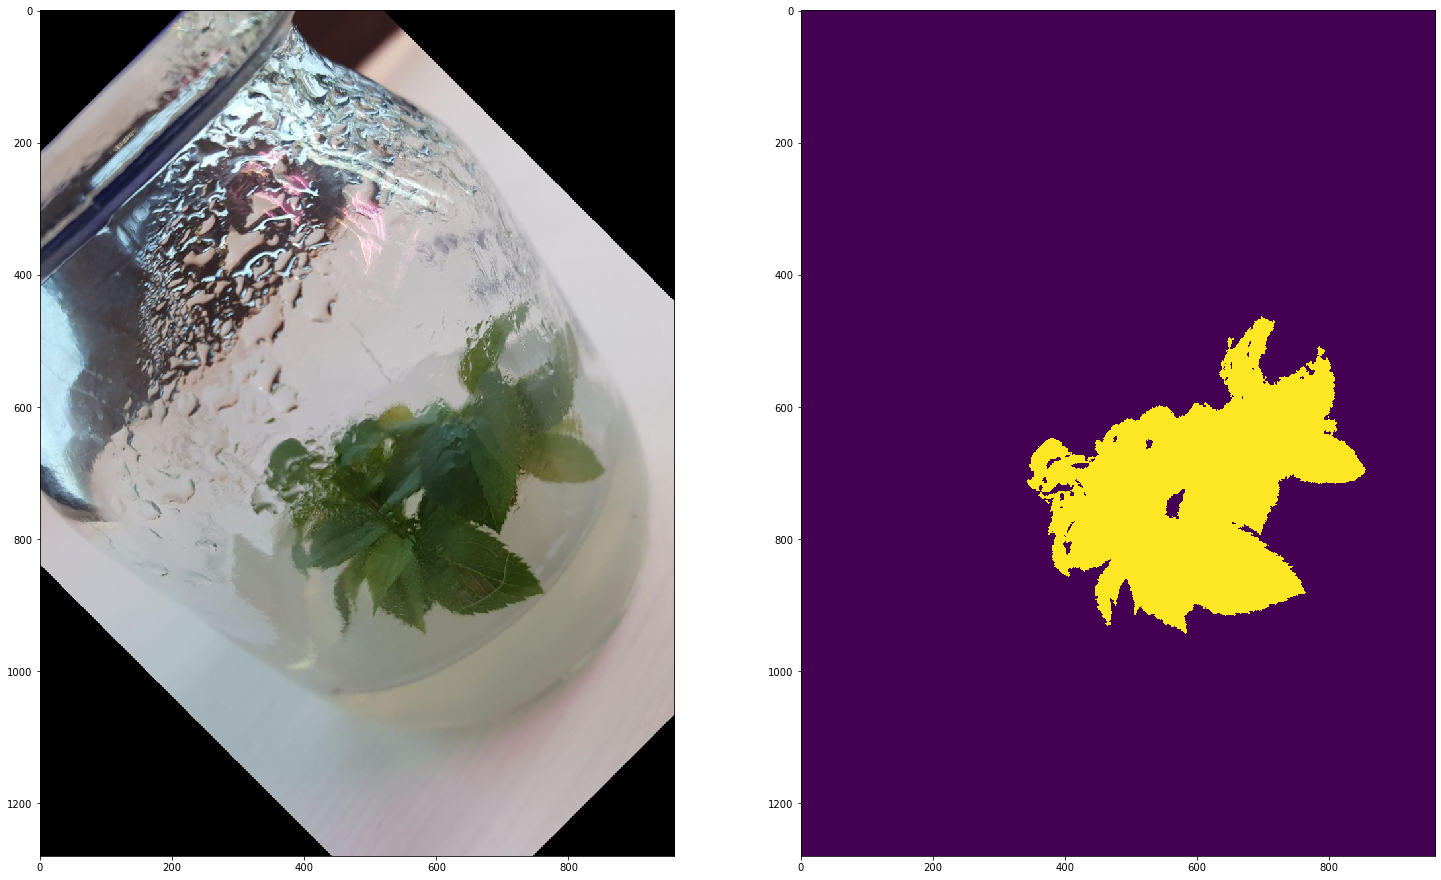

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,25)) 

axes[0].imshow(train_x[-1][:,:,::-1])
axes[1].imshow(train_y[-1][...,0])
# cv2.imshow('img', train_y[-1])
# cv2.waitKey(0)

plt.show()

In [12]:
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

train_x = preprocess_input(train_x)

In [13]:
# base_model = VGG16(weights='imagenet', input_shape=(width, height, 3), include_top=False)

# base_out = base_model.output

# up = UpSampling2D(32, interpolation='bilinear')(base_out)
# conv = Conv2D(1, (1, 1))(up)
# conv = Activation('sigmoid')(conv)

# model = Model(input=base_model.input, output=conv)

model = sm.Unet(BACKBONE, encoder_weights='imagenet')


58892288/58889256 [==============================] - 300s 5us/step


In [14]:

best_w = keras.callbacks.ModelCheckpoint('../models/fcn_best.h5', 
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=True,
                                        save_weights_only=True,
                                        mode='auto',
                                        period=1)

last_w = keras.callbacks.ModelCheckpoint('../models/fcn_last.h5', 
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=False,
                                        save_weights_only=True,
                                        mode='auto',
                                        period=1)

callbacks = [best_w, last_w]

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["binary_accuracy"])

In [ ]:
history = model.fit(train_x, train_y, epochs=10, verbose=1, batch_size=1, callbacks=callbacks, validation_split=0.3)

Train on 53 samples, validate on 24 samples
Epoch 1/10
53/53 [==============================] - 1723s 33s/step - loss: 0.3110 - binary_accuracy: 0.9084 - val_loss: 0.2930 - val_binary_accuracy: 0.9682
Epoch 2/10
53/53 [==============================] - 1716s 32s/step - loss: 0.0731 - binary_accuracy: 0.9878 - val_loss: 0.0886 - val_binary_accuracy: 0.9835
Epoch 3/10
53/53 [==============================] - 1734s 33s/step - loss: 0.0467 - binary_accuracy: 0.9889 - val_loss: 0.0495 - val_binary_accuracy: 0.9849
Epoch 4/10
53/53 [==============================] - 1728s 33s/step - loss: 0.0384 - binary_accuracy: 0.9901 - val_loss: 0.0343 - val_binary_accuracy: 0.9899
Epoch 5/10
53/53 [==============================] - 1717s 32s/step - loss: 0.0338 - binary_accuracy: 0.9905 - val_loss: 0.0496 - val_binary_accuracy: 0.9823
Epoch 6/10
53/53 [==============================] - 1725s 33s/step - loss: 0.0315 - binary_accuracy: 0.9909 - val_loss: 0.0262 - val_binary_accuracy: 0.9915
Epoch 7/10
53/

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_x, test_y)

In [ ]:
pred = model.predict(test_x)

im_id = 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,25))
axes[0].imshow(test_x[im_id][:,:,::-1])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()